In [1]:
import sys

sys.path.append("../")


import polars as pl
import matplotlib.pyplot as plt

from stravalib_wrapper import *
from database import *
from time_series_parser import *
from time_series_functions import *

import numpy as np

%load_ext autoreload
%autoreload 2

## Normalized power for a fit file

In [2]:
df = get_spine(root_path="../")

In [3]:
def compute_normalized_power(filename, root_path) -> np.float64:
    try:
        file_path = os.path.join(root_path, filename)
        if file_path.endswith(".fit"):
            ts_df = fit_power_adapter(parse_fit_file(file_path))
        elif file_path.endswith(".json"):
            ts_df = strava_api_power_adapter(parse_strava_series(file_path))
        return (ts_df.filter(pl.col("fIsMoving")).select(normalized_power()))[
            "Normalized power"
        ][0]
    except pl.exceptions.ColumnNotFoundError:
        return None

In [4]:
pl.Config.set_tbl_width_chars(-1)
pl.Config.set_fmt_str_lengths(1000)

polars.config.Config

In [6]:
compute_normalized_power("fit_files/activities/17565962602.fit", "../")

203.6184796078397

In [10]:
dfnp = df.with_columns(
    pl.col("Filename")
    .map_elements(lambda f: compute_normalized_power(f, "../"), return_dtype=pl.Float64)
    .alias("Normalized power")
)

In [11]:
dfnp["Normalized power"].describe()

statistic,value
str,f64
"""count""",476.0
"""null_count""",591.0
"""mean""",195.918287
"""std""",41.237361
"""min""",0.0
"""25%""",173.212653
"""50%""",191.386813
"""75%""",205.827355
"""max""",340.516957


In [25]:
f_valid = (
    (pl.col("Normalized power") >= 50)
    & (pl.col("Normalized power").is_finite())
    & (pl.col("Distance") >= 30)
)

In [26]:
dfnp.filter(f_valid)["Normalized power"].describe()

statistic,value
str,f64
"""count""",260.0
"""null_count""",0.0
"""mean""",187.775704
"""std""",21.135556
"""min""",83.577703
"""25%""",173.807277
"""50%""",189.986071
"""75%""",202.188672
"""max""",229.768207


In [38]:
bikes = dfnp.filter(f_valid)["Activity Gear"].value_counts()

In [39]:
bikes

Activity Gear,count
str,u32
"""Kreissäge""",8
"""Salsa Fargo""",15
"""Trek Domane Al""",56
null,1
"""Bianchi Volpe""",16
"""Pink Bridgestone""",10
"""Lauf Seigla""",154


In [40]:
filters = []
for b in bikes["Activity Gear"]:
    f = pl.col("Activity Gear") == b
    filters.append((b,f))

  f = pl.col("Activity Gear") == b



In [41]:
filters

[('Kreissäge', <Expr ['[(col("Activity Gear")) == ("K…'] at 0x1454BF590>),
 ('Salsa Fargo', <Expr ['[(col("Activity Gear")) == ("S…'] at 0x1361DE110>),
 ('Trek Domane Al', <Expr ['[(col("Activity Gear")) == ("T…'] at 0x1361DD050>),
 (None, <Expr ['[(col("Activity Gear")) == (nu…'] at 0x14556D650>),
 ('Bianchi Volpe', <Expr ['[(col("Activity Gear")) == ("B…'] at 0x160FC5850>),
 ('Pink Bridgestone',
  <Expr ['[(col("Activity Gear")) == ("P…'] at 0x1165C8310>),
 ('Lauf Seigla', <Expr ['[(col("Activity Gear")) == ("L…'] at 0x152F65910>)]

In [54]:
markers = [
    "o",
    "^",
    "P",
    "*",
    "x",
    "d",
    "s",
]

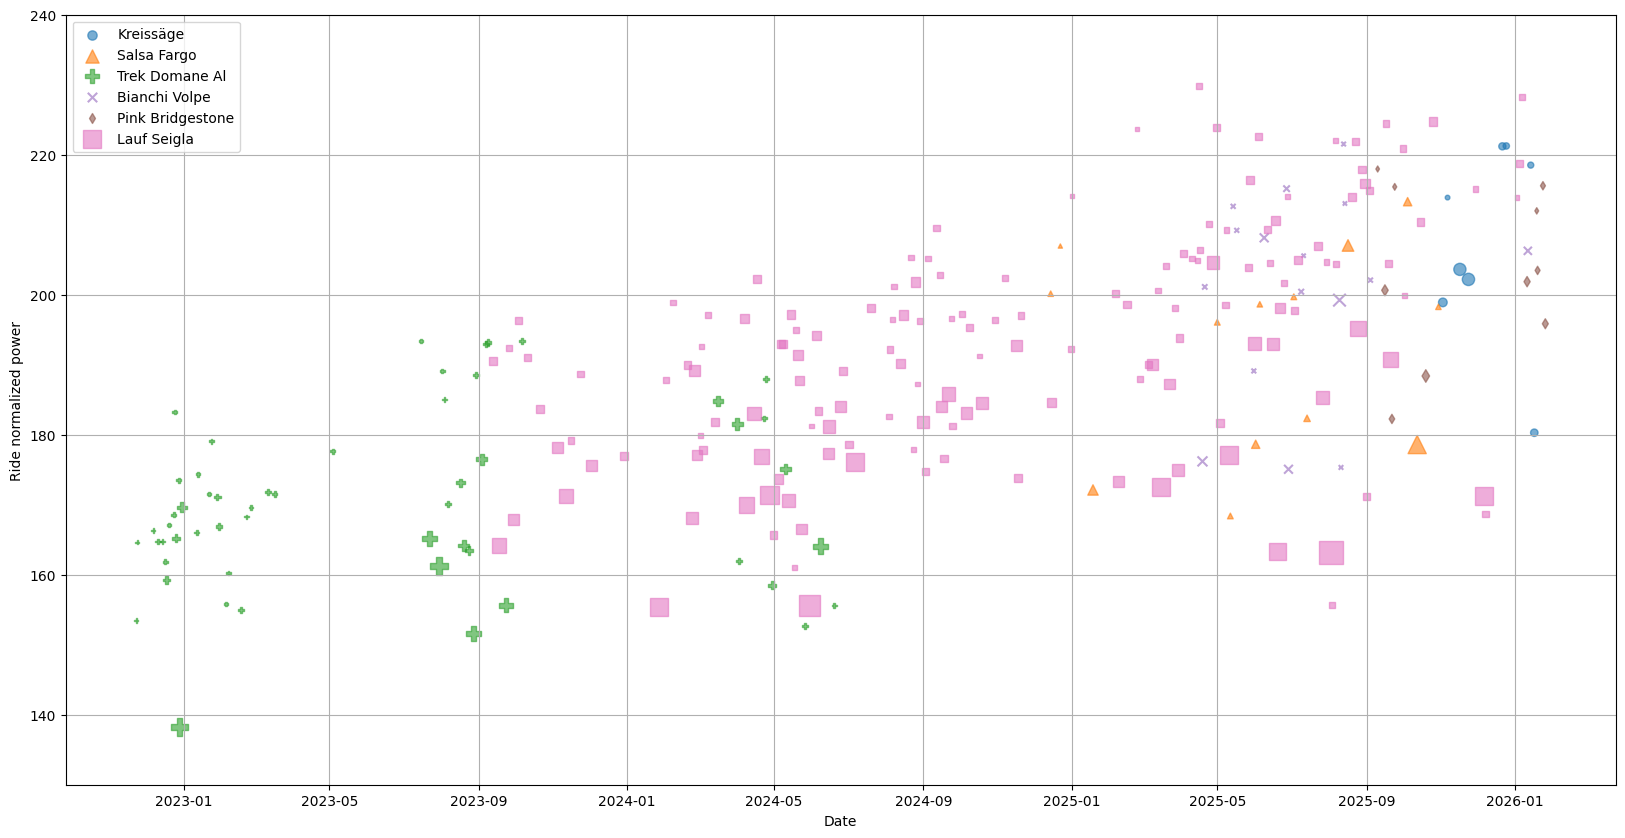

In [63]:
plt.figure(figsize=(20, 10))

for (b,f), m in zip(filters, markers):
    plt.scatter(
        dfnp.filter(f_valid & f)["Activity Date"],
        dfnp.filter(f_valid & f)["Normalized power"],
        s=(dfnp.filter(f_valid & f)["Distance"] / 20)**1.5 * 5,
        marker=m,
        label=b,
        alpha=0.6,
    )

plt.ylim((130, 240))
plt.legend(loc=2)

plt.xlabel("Date")
plt.ylabel("Ride normalized power")

plt.grid()